In [1]:
import numpy as np
from lib.models.diffusion_model import CategoricalDiffusionModel
from lib.config.config_mnist_loss import get_config
import lib.optimizer.optimizer as optim
import lib.utils.bookkeeping as bookkeeping
import lib.datasets.datasets_utils as datasets_utils
from lib.datasets.datasets import get_dataloader
import lib.utils.utils as utils
import jax
import jax.numpy as jnp
from tqdm import tqdm
import os


/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_resume = False

if not train_resume:
    config = get_config()
    bookkeeping.save_config(config, config.save_dir)

else:
    path = 'SavedModels/MNIST'
    date = '2023-10-07'
    config_name = 'config_001.yaml'
    config_path = os.path.join(path, date, config_name)

    config = bookkeeping.load_config(config_path)

train_ds = datasets_utils.numpy_iter(get_dataloader(config, "train"))

#optimizer = optim.build_optimizer(config)
#fwd_model = build_utils.build_fwd_model(config)
#net = build_utils.build_network(config)
#backwd_model = build_utils.build_backwd_model(config, fwd_model, net)

model = CategoricalDiffusionModel(config)

global_key = jax.random.PRNGKey(1008)
train_key, model_key, sample_key = jax.random.split(global_key, 3)

# struct with step, params state, optimizer state, ema state
state = model.init_state(model_key)
print("Number of parameters:", sum(x.size for x in jax.tree_util.tree_leaves(state.params)))

if train_resume:
    load_dir = 'SavedModels/MNIST'
    date = '2023-10-07'
    model_name = 'checkpoint_600'
    checkpoint_path = os.path.join(path, date, model_name)
    state = bookkeeping.load_model(checkpoint_path, state)
    config.total_train_steps = 200
    config.sampling_steps = 1000 
    config.sample_freq = 5
    config.checkpoint_freq = 2
    bookkeeping.save_config(config, config.save_dir)

init_step = state.step
#state = flax.jax_utils.replicate(state)
print("Init Step", init_step)

# replicate state over several devices: if one nothing happens
# every device, process, got different rng key
process_rng_key = jax.random.fold_in(train_key, jax.process_index())
# functions over several devices
#
train_step_fn = model.training_step
# train_step_fn = jax.pmap(train_step_fn, axis_name="shard")
#train_step_fn = jax.jit(train_step_fn)
lr_schedule = optim.build_lr_schedule(config)

n_samples = 16



Number of parameters: 2207232
Init Step 0


  0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 1
loss  <class 'jax._src.interpreters.ad.JVPTracer'> Traced<ConcreteArray(4661.10791015625, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(4661.108, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x14457dae0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(64.0, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x14459d850; to 'JaxprTracer' at 0x14459d710>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Trace

 50%|█████     | 1/2 [01:48<01:48, 108.19s/it]

backward time 101.62677907943726
Iteration: 2
loss  <class 'jax._src.interpreters.ad.JVPTracer'> Traced<ConcreteArray(4656.9033203125, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(4656.9033, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x1453d1440>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(64.0, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x1452fa250; to 'JaxprTracer' at 0x1452fbab0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(trac

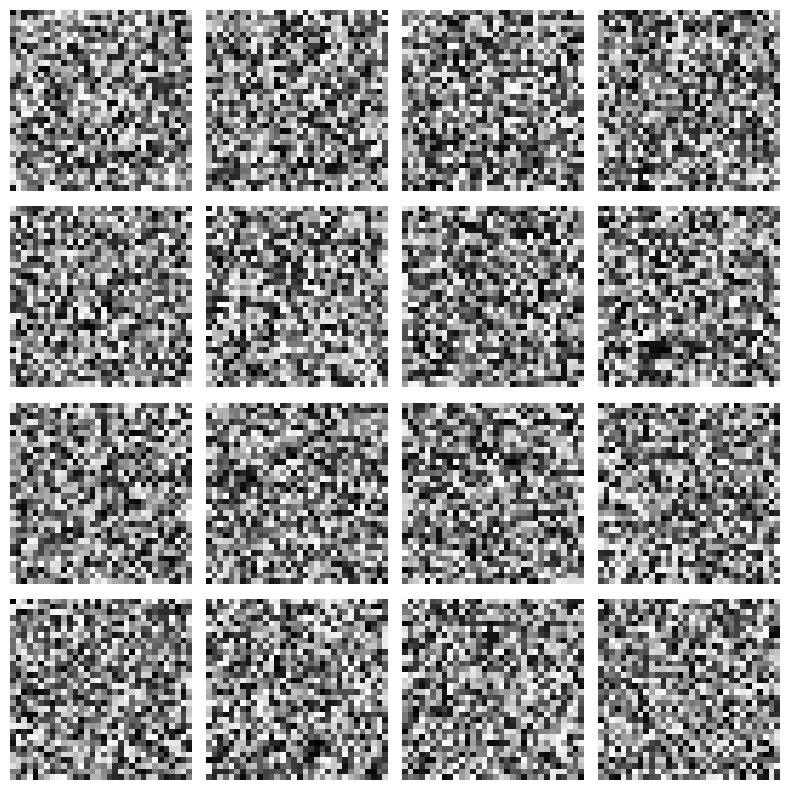

100%|██████████| 2/2 [03:00<00:00, 90.23s/it] 


In [3]:

for step in tqdm(range(init_step + 1, config.total_train_steps + 1)):
    print("Iteration:", step)

    #batch = fn_data_preprocess(next(train_ds))
    batch = next(train_ds)
    process_rng_key, step_key = jax.random.split(process_rng_key)
    process_step_rng_key = jax.random.fold_in(step_key, step)
    
    # for cpu: 
    # process_rng_key = jax.random.fold_in(process_rng_key, step)
    #step_rng_keys = process_rng_key
    #step_rng_keys = utils.shard_prng_key(process_rng_key)
    
    state, aux = train_step_fn(state, process_step_rng_key, batch)

    #if step % config.log_every_steps == 0:
    #    aux = jax.device_get(flax.jax_utils.unreplicate(aux))
    #    aux["train/lr"] = lr_schedule(step)
    if (step) % config.checkpoint_freq == 0 or step == config.total_train_steps:
        bookkeeping.save_model(config.save_dir, state, step)
    
    if step % config.sample_freq == 0 or step == config.total_train_steps:
        sample_key, sub_sample_key = jax.random.split(sample_key)
        process_sample_rng_key = jax.random.fold_in(sub_sample_key, step)
        
        samples = model.sample_loop(state, process_sample_rng_key, n_samples, conditioner=None)
        #  samples = utils.all_gather(samples)
        samples = jnp.reshape(samples, (n_samples, config.image_size, config.image_size, 1))
        saving_plot_path = os.path.join(config.sample_plot_path, f"samples_epoch_{step}.png")
        datasets_utils.plot_mnist_batch(samples, saving_plot_path)
    
        
    

In [ ]:
# config.image_size = 28
#saving_plot_path = os.path.join(config.sample_plot_path, f"samples_epoch_{0}.png")
#datasets_utils.plot_mnist_batch(jnp.reshape(next(train_ds), (64, config.image_size, config.image_size, 1)), saving_plot_path)
print("Finished!")